In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from itertools import product

In [2]:
# Price for zero coupon bond
def ZCbond(F, r, t, T):
    return F*np.exp(-r*(T-t))

In [3]:
def rpoi(a, y, lam, T):
    return np.exp(lam * T * (np.exp(a) - 1) - a * y)

In [4]:
# MC with gamma distribution for the size of losses
def naive_MC_gamma(nr = 20000,lam=35,D=9000000000,T=1, k=1, th=163500000):
    h = []
    poissons = np.random.poisson(lam=lam*T, size=nr)
    for i in range(nr):
        x = np.sum(np.random.gamma(shape=k, scale=th, size=poissons[i]))
        h.append(int(x>D))
    return np.cumsum(h)/np.arange(1,nr+1)

In [43]:
def naive_MC_gamma_test(nr = 20000,lam=35,D=9000000000,T=1, k=1, th=163500000):
    h = []
    poissons = np.random.poisson(lam=lam*T, size=nr)
    for i in range(nr):
        x = np.sum(np.random.gamma(shape=k, scale=th, size=poissons[i]))
        h.append(int(x>D))
    mean_estimte = np.mean(h)
    variance = np.var(h)/2
    return mean_estimte, variance

mean_estimate, variance = naive_MC_gamma_test(nr = 20000,lam=35,D=9000000000,T=1, k=1, th=163500000)
print(f"{mean_estimate:>15.5f} | {variance:>10.7f}")

        0.01480 |  0.0072905


In [5]:
def rgamma(a, y, k, th, n):
    return (1-th*a)**(-k*n) / np.exp(a * y)

In [6]:
# Lognormal parameters for the target distribution
c_values = np.linspace(0.75, 1, 6)
d_values = np.linspace(1, 2.5, 4)  

import numpy as np

def MC_IS_gamma_poi(nr=20000, lam=35,D=9000000000,T=1, k=1, th=163500000, c=0.5, d=2):
    # Initial variables
    a_poi = np.log(c*D / (lam * T * k * th))
    poisson_means = lam * T * np.exp(a_poi)
    a_gamma = 1/th - (k * poisson_means)/(d*D)
    new_th = 1/(1/th - a_gamma)

    # Preallocate memory for cumulative sums
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_gamma = np.zeros(nr)
    
    # Loop over the number of simulations
    for i in range(nr):
        # Generate Poisson-distributed count
        poissons = np.random.poisson(lam=poisson_means)

        # Generate the exponential random variables for this count
        # Directly sum them without creating large intermediate arrays
        x = np.sum(np.random.gamma(shape=k, scale=new_th, size=poissons))

        # Compute h and r for this simulation
        h[i] = int(x > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_gamma[i] = rgamma(a_gamma, x, k, th, poissons)

    # Compute weighted values
    weighted_values = h * r_poi * r_gamma
    
    # Compute mean estimate
    mean_estimate = np.mean(weighted_values)
    
    # Compute variance of the estimator
    variance = np.var(weighted_values)/2

    return mean_estimate, variance

results = []

parameter_grid = list(product(c_values, d_values))

print(f"Total pairs of test: {len(parameter_grid)}")

for c,d in parameter_grid:
    
    if c < d:
        # Compute mean and variance of the estimator
        mean_estimate, variance = MC_IS_gamma_poi(nr=20000, lam=35,D=9000000000,T=1, k=1, th=163500000, c=c, d=d)
    
        results.append((c, d, mean_estimate, variance))

# Display results
print(f"{'c':>5} | {'d':>5} | {'Mean Estimate':>15} | {'Variance':>10}")
print("-" * 45)
for c, d, mean_estimate, variance in results:
    print(f"{c:>5.2f} |{d:>5.2f} | {mean_estimate:>15.5f} | {variance:>10.7f}")

Total pairs of test: 24
    c |     d |   Mean Estimate |   Variance
---------------------------------------------
 0.75 | 1.00 |         0.01449 |  0.0005008
 0.75 | 1.50 |         0.01393 |  0.0460364
 0.75 | 2.00 |         0.00413 |  0.0310534
 0.75 | 2.50 |         0.00069 |  0.0038429
 0.80 | 1.00 |         0.01432 |  0.0003142
 0.80 | 1.50 |         0.01766 |  0.0440174
 0.80 | 2.00 |         0.00553 |  0.0253070
 0.80 | 2.50 |         0.00079 |  0.0015716
 0.85 | 1.00 |         0.01478 |  0.0005106
 0.85 | 1.50 |         0.01431 |  0.0079863
 0.85 | 2.00 |         0.01147 |  0.0750862
 0.85 | 2.50 |         0.00026 |  0.0000698
 0.90 | 1.00 |         0.01448 |  0.0012556
 0.90 | 1.50 |         0.01403 |  0.0027384
 0.90 | 2.00 |         0.01612 |  0.2306043
 0.90 | 2.50 |         0.00379 |  0.1024892
 0.95 | 1.00 |         0.01454 |  0.0038789
 0.95 | 1.50 |         0.01398 |  0.0017124
 0.95 | 2.00 |         0.01253 |  0.0521171
 0.95 | 2.50 |         0.00160 |  0.0038195
 1.00

In [7]:
# Importance sampling for default probability
def MC_IS_gamma_poi(nr=20000, lam=35,D=9000000000,T=1, k=1, th=163500000):
    # Initial variables
    a_poi = np.log(0.8*D / (lam * T * k * th))
    poisson_means = lam * T * np.exp(a_poi)
    a_gamma = 1/th - (k * poisson_means)/D
    new_th = 1/(1/th - a_gamma)

    # Preallocate memory for cumulative sums
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_gamma = np.zeros(nr)
    
    # Loop over the number of simulations
    for i in range(nr):
        # Generate Poisson-distributed count
        poissons = np.random.poisson(lam=poisson_means)

        # Generate the exponential random variables for this count
        # Directly sum them without creating large intermediate arrays
        x = np.sum(np.random.gamma(shape=k, scale=new_th, size=poissons))

        # Compute h and r for this simulation
        h[i] = int(x > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_gamma[i] = rgamma(a_gamma, x, k, th, poissons)

    # Calculate cumulative sum and return the average at each step
    cumulative_sum = np.cumsum(h * r_poi * r_gamma)
    cumulative_avg = cumulative_sum / np.arange(1, nr + 1)

    return cumulative_avg

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


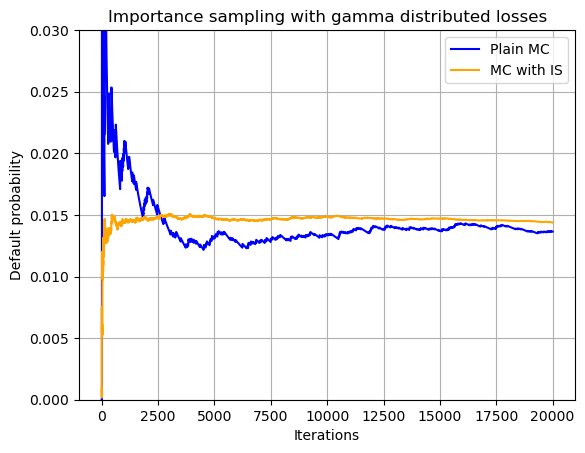

In [8]:
plt.plot(naive_MC_gamma(),color = "blue",label = "Plain MC")
plt.plot(MC_IS_gamma_poi(),color = "orange",label = "MC with IS")
plt.title("Importance sampling with gamma distributed losses")
plt.ylim([0,0.03])
plt.xlabel("Iterations")
plt.ylabel("Default probability")
plt.legend()
plt.grid()
plt.savefig('IS_gamma.eps', format='eps')
plt.show()

In [9]:
# MC with lognormal distribution for the size of losses
def naive_MC_log(nr = 20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1):
    h = []
    poissons = np.random.poisson(lam=lam*T, size=nr)
    for i in range(nr):
        x = np.sum(np.random.lognormal(mean=mu, sigma=sig, size = poissons[i]))
        h.append(int(x>D))
    return np.cumsum(h)/np.arange(1,nr+1)

In [39]:
def naive_MC_log_test(nr = 20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1):
    h = []
    poissons = np.random.poisson(lam=lam*T, size=nr)
    for i in range(nr):
        x = np.sum(np.random.lognormal(mean=mu, sigma=sig, size = poissons[i]))
        h.append(int(x>D))
    mean_estimte = np.mean(h)
    variance = np.var(h)/2
    return mean_estimte, variance

mean_estimate, variance = naive_MC_log_test(nr = 20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1)
print(f"{mean_estimate:>15.5f} | {variance:>10.7f}")

        0.02950 |  0.0143149


In [10]:
def rlog(a, y, mu, sig, n):
    return np.exp(((mu+a)**2-mu**2)/(2*sig**2))**n / np.exp(a * y/(sig**2))

def rlog2(a, b, y, z, mu, sig, n):
    new_mu = mu+a
    new_sig = sig*b
    return b*np.exp((1/(2*new_sig**2)-1/(2*sig**2))*z) * np.exp((mu/sig**2 - new_mu/new_sig**2)*y) * np.exp(new_mu**2/(2*new_sig**2) - mu**2/(2*sig**2))**n

In [36]:
# Lognormal parameters for the target distribution
c_values = np.linspace(0.75, 0.8, 6)
d_values = np.linspace(1, 1.2, 3)

import numpy as np

def MC_IS_log_poi(nr=20000, lam=35,D=9000000000,T=1, mu=18.4, sig=1, c=0.25, d=2):
    # Initial variable
    a_poi = np.log(c*D / (lam * T * np.exp(mu+sig**2/2)))
    poisson_means = lam * T * np.exp(a_poi)
    a_log = np.log(d*D/poisson_means) - (mu+sig**2/2)
    new_mu = mu+a_log

    # Preallocate memory
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_log = np.zeros(nr)
    
    # Loop over simulations
    for i in range(nr):
        poissons = np.random.poisson(lam=poisson_means)
        x = np.random.normal(loc=new_mu, scale=sig, size=poissons)
        y = np.sum(x)
        z = np.sum(np.exp(x))

        h[i] = int(z > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_log[i] = rlog(a_log, y, mu, sig, poissons)

    # Compute weighted values
    weighted_values = h * r_poi * r_log
    
    # Compute mean estimate
    mean_estimate = np.mean(weighted_values)
    
    # Compute variance of the estimator
    variance = np.var(weighted_values)/2

    return mean_estimate, variance

results = []

parameter_grid = list(product(c_values, d_values))

print(f"Total pairs of test: {len(parameter_grid)}")

for c,d in parameter_grid:
    
    if c < d:
    
        # Compute mean and variance of the estimator
        mean_estimate, variance = MC_IS_log_poi(nr=20000,lam=35,D=9000000000,T=1, mu=18.4, sig=1, c=c, d=d)
    
        results.append((c, d, mean_estimate, variance))

# Display results
print(f"{'c':>5} | {'d':>5} | {'Mean Estimate':>15} | {'Variance':>15}")
print("-" * 45)
for c, d, mean_estimate, variance in results:
    print(f"{c:>5.2f} | {d:>5.2f} | {mean_estimate:>15.5f} | {variance:>15.7f}")

Total pairs of test: 18
    c |     d |   Mean Estimate |        Variance
---------------------------------------------
 0.75 |  1.00 |         0.02924 |       0.0079348
 0.75 |  1.10 |         0.03005 |       0.0290268
 0.75 |  1.20 |         0.02776 |       0.0300921
 0.76 |  1.00 |         0.02861 |       0.0071665
 0.76 |  1.10 |         0.02674 |       0.0113517
 0.76 |  1.20 |         0.03158 |       0.1164844
 0.77 |  1.00 |         0.03021 |       0.0108291
 0.77 |  1.10 |         0.02739 |       0.0146311
 0.77 |  1.20 |         0.02889 |       0.1269116
 0.78 |  1.00 |         0.02953 |       0.0060541
 0.78 |  1.10 |         0.02836 |       0.0167506
 0.78 |  1.20 |         0.03029 |       0.1338515
 0.79 |  1.00 |         0.03051 |       0.0098891
 0.79 |  1.10 |         0.02823 |       0.0112735
 0.79 |  1.20 |         0.02662 |       0.0177039
 0.80 |  1.00 |         0.03453 |       0.0429572
 0.80 |  1.10 |         0.03252 |       0.0469367
 0.80 |  1.20 |         0.0298

In [25]:
# Importance sampling for default probability
def MC_IS_log_poi(nr=20000, lam=35,D=9000000000,T=1, mu=18.4, sig=1):
    # Initial variables
    a_poi = np.log(0.76 * D / (lam * T * np.exp(mu+sig**2/2)))
    poisson_means = lam * T * np.exp(a_poi)
    a_log = np.log(D/poisson_means) - (mu+sig**2/2)
    new_mu = mu+a_log

    # Preallocate memory for cumulative sums
    h = np.zeros(nr)
    r_poi = np.zeros(nr)
    r_log = np.zeros(nr)
    
    # Loop over the number of simulations
    for i in range(nr):
        # Generate Poisson-distributed count
        poissons = np.random.poisson(lam=poisson_means)

        # Generate the exponential random variables for this count
        # Directly sum them without creating large intermediate arrays
        x = np.random.normal(loc=new_mu, scale=sig, size=poissons)
        y = np.sum(x)
        z = np.sum(np.exp(x))

        # Compute h and r for this simulation
        h[i] = int(z > D)
        r_poi[i] = rpoi(a_poi, poissons, lam, T)
        r_log[i] = rlog(a_log, y, mu, sig, poissons)

    # Calculate cumulative sum and return the average at each step
    cumulative_sum = np.cumsum(h * r_poi * r_log)
    cumulative_avg = cumulative_sum / np.arange(1, nr + 1)

    return cumulative_avg

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


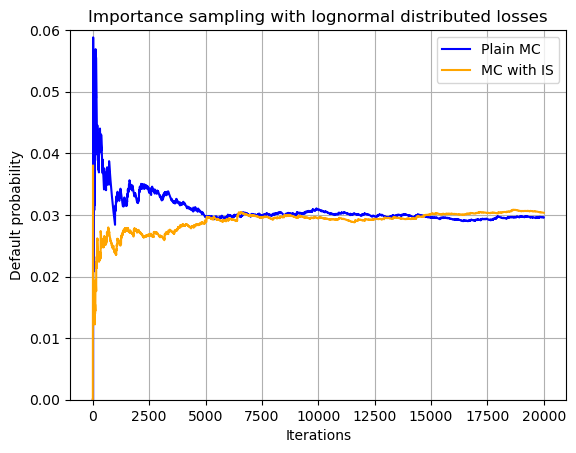

In [26]:
plt.plot(naive_MC_log(),color = "blue",label = "Plain MC")
plt.plot(MC_IS_log_poi(),color = "orange",label = "MC with IS")
plt.title("Importance sampling with lognormal distributed losses")
plt.ylim([0,0.06])
plt.xlabel("Iterations")
plt.ylabel("Default probability")
plt.legend()
plt.grid()
plt.savefig('IS_lognormal.eps', format='eps')
plt.show()